### **Implementation of Recurrent Neural Network**

In [1]:
#importing the required libraries
import torch

print("PyTorch Version : {}".format(torch.__version__))

PyTorch Version : 1.13.0+cpu


In [2]:
import torchtext

print("TorchText Version : {}".format(torchtext.__version__))

TorchText Version : 0.14.0


In [3]:
from torch.utils.data import DataLoader

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()

In [4]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")

def build_vocabulary(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocabulary([train_dataset, test_dataset]), min_freq=1, specials=["<UNK>"])

vocab.set_default_index(vocab["<UNK>"])

In [5]:
len(vocab)

98635

In [6]:
tokens = tokenizer("Hello how are you?, Welcome to Recureent Neural Network")
indexes = vocab(tokens)

tokens, indexes

(['hello',
  'how',
  'are',
  'you',
  '?',
  ',',
  'welcome',
  'to',
  'recureent',
  'neural',
  'network'],
 [12388, 355, 42, 164, 80, 3, 3298, 4, 0, 82087, 200])

In [7]:
vocab["<UNK>"] ## Coderzcolumn word is mapped to unknown as it's new and not present in vocabulary

0

In [8]:
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
train_dataset, test_dataset  = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

target_classes = ["World", "Sports", "Business", "Sci/Tech"]

max_words = 25

def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab(tokenizer(text)) for text in X]
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.

    return torch.tensor(X, dtype=torch.int32), torch.tensor(Y) - 1 ## We have deducted 1 from target names to get them in range [0,1,2,3] from [1,2,3,4]


train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=1024, collate_fn=vectorize_batch)

In [9]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([1024, 25]) torch.Size([1024])


In [10]:
from torch import nn
from torch.nn import functional as F

embed_len = 50
hidden_dim = 50
n_layers=1

class RNNClassifier(nn.Module):
    def __init__(self):
        super(RNNClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.rnn = nn.RNN(input_size=embed_len, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(target_classes))

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(embeddings, torch.randn(n_layers, len(X_batch), hidden_dim))
        return self.linear(output[:,-1])

In [11]:
rnn_classifier = RNNClassifier()

rnn_classifier

RNNClassifier(
  (embedding_layer): Embedding(98635, 50)
  (rnn): RNN(50, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=4, bias=True)
)

In [12]:
for layer in rnn_classifier.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(98635, 50)
Parameters : 
torch.Size([98635, 50])

Layer : RNN(50, 50, batch_first=True)
Parameters : 
torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([50])

Layer : Linear(in_features=50, out_features=4, bias=True)
Parameters : 
torch.Size([4, 50])
torch.Size([4])



In [13]:
out = rnn_classifier(torch.randint(0, len(vocab), (1024, max_words)))

out.shape

torch.Size([1024, 4])

In [14]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLossAndAccuracy(model, loss_fn, val_loader)

In [15]:
from torch.optim import Adam

epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
rnn_classifier = RNNClassifier()
optimizer = Adam(rnn_classifier.parameters(), lr=learning_rate)

TrainModel(rnn_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 118/118 [00:23<00:00,  5.12it/s]


Train Loss : 1.306


  1%|          | 1/118 [00:00<00:21,  5.45it/s]

Valid Loss : 1.109
Valid Acc  : 0.513


100%|██████████| 118/118 [00:21<00:00,  5.53it/s]


Train Loss : 0.929


  1%|          | 1/118 [00:00<00:21,  5.38it/s]

Valid Loss : 0.797
Valid Acc  : 0.682


100%|██████████| 118/118 [00:21<00:00,  5.40it/s]


Train Loss : 0.688


  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss : 0.646
Valid Acc  : 0.756


100%|██████████| 118/118 [00:20<00:00,  5.63it/s]


Train Loss : 0.554


  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss : 0.569
Valid Acc  : 0.791


100%|██████████| 118/118 [00:20<00:00,  5.73it/s]


Train Loss : 0.478


  1%|          | 1/118 [00:00<00:22,  5.16it/s]

Valid Loss : 0.507
Valid Acc  : 0.821


100%|██████████| 118/118 [00:20<00:00,  5.68it/s]


Train Loss : 0.423


  1%|          | 1/118 [00:00<00:21,  5.48it/s]

Valid Loss : 0.485
Valid Acc  : 0.834


100%|██████████| 118/118 [00:23<00:00,  5.10it/s]


Train Loss : 0.384


  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss : 0.464
Valid Acc  : 0.843


100%|██████████| 118/118 [00:22<00:00,  5.16it/s]


Train Loss : 0.352


  1%|          | 1/118 [00:00<00:23,  4.94it/s]

Valid Loss : 0.447
Valid Acc  : 0.851


100%|██████████| 118/118 [00:26<00:00,  4.52it/s]


Train Loss : 0.325


  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss : 0.439
Valid Acc  : 0.853


100%|██████████| 118/118 [00:23<00:00,  5.09it/s]


Train Loss : 0.302


  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss : 0.436
Valid Acc  : 0.856


100%|██████████| 118/118 [00:24<00:00,  4.79it/s]


Train Loss : 0.285


  1%|          | 1/118 [00:00<00:23,  5.09it/s]

Valid Loss : 0.417
Valid Acc  : 0.864


100%|██████████| 118/118 [00:21<00:00,  5.50it/s]


Train Loss : 0.265


  1%|          | 1/118 [00:00<00:23,  5.07it/s]

Valid Loss : 0.426
Valid Acc  : 0.862


100%|██████████| 118/118 [00:20<00:00,  5.76it/s]


Train Loss : 0.253


  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss : 0.413
Valid Acc  : 0.864


100%|██████████| 118/118 [00:23<00:00,  5.02it/s]


Train Loss : 0.238


  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss : 0.408
Valid Acc  : 0.870


100%|██████████| 118/118 [00:21<00:00,  5.54it/s]


Train Loss : 0.224
Valid Loss : 0.416
Valid Acc  : 0.869


In [16]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(rnn_classifier, test_loader)

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))


Test Accuracy : 0.8697368421052631

Classification Report : 
              precision    recall  f1-score   support

       World       0.88      0.86      0.87      1900
      Sports       0.93      0.94      0.93      1900
    Business       0.83      0.83      0.83      1900
    Sci/Tech       0.84      0.85      0.84      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600


Confusion Matrix : 
[[1642   84  109   65]
 [  56 1782   24   38]
 [  96   19 1579  206]
 [  62   35  196 1607]]


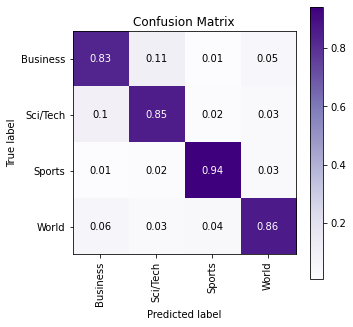

In [21]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);